In [41]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import ipywidgets as ipw
import os
import qgrid
from datetime import datetime
import altair as alt

In [2]:
PROCESSED_DATA_PATH = os.path.join("..","data","processed")

In [38]:
def parse_date(date_str):
    yy,mm,dd = [int(i) for i in date_str.split('-')]
    return datetime(yy,mm,dd)

def parse_point(point_str, latitude=True):
    if not point_str or point_str is None or point_str is np.nan:
        return None
    lat,lon = point_str.split('(',)[1].replace(')','').split()
    return float(lat) if latitude else float(lon)

# Reading Sample Data

In [15]:
data = pd.read_csv(os.path.join(PROCESSED_DATA_PATH,'sample.csv'),parse_dates=['date'],date_parser=parse_date)

In [30]:
data.drop('Unnamed: 0',axis=1,inplace=True)

In [31]:
data.columns

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description', 'pack', 'bottle_volume_ml',
       'state_bottle_cost', 'state_bottle_retail', 'bottles_sold',
       'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons',
       'invoice_number', 'to_sample', 'bad_invoice'],
      dtype='object')

In [39]:
data['invoice_letter'] = data.invoice_and_item_number.apply(lambda x: x[0])
data['latitude'] = data.store_location.map(lambda x: parse_point(x))
data['longitude'] = data.store_location.map(lambda x: parse_point(x,False))

In [40]:
data.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,invoice_number,to_sample,bad_invoice,invoice_letter,latitude,longitude
0,S03731700008,2012-01-25,4090,Mcelroy's Food Market,135 MADISON ST,WINTHROP,50682,POINT (-92.53666400000002 42.951717),10.0,Buchanan,...,1,15.35,1.0,0.26,S037317,True,False,S,-92.536664,42.951717
1,S06944000033,2012-08-06,4183,Fareway Stores #589 / Decorah,103 E MAIN,DECORAH,52101,POINT (-91.785286 43.303291),96.0,Winneshiek,...,1,13.55,1.0,0.26,S069440,True,False,S,-91.785286,43.303291
2,S26729300053,2015-07-14,2522,Hy-Vee Wine and Spirits / Spirit Lak,HWY 9 & 71,SPIRIT LAKE,51360,NaN,30.0,Dickinson,...,2,14.86,1.0,0.26,S267293,True,False,S,NaN,NaN
3,S16161000033,2013-12-09,3957,Karl's Grocery Store,101 WEST MADISON,EDGEWOOD,52042,POINT (-91.401487 42.645390000000006),22.0,Clayton,...,1,14.99,1.0,0.26,S161610,True,False,S,-91.401487,42.645390
4,S15896500182,2013-11-22,3456,Quick Shop / Clear Lake,904 N 8TH ST,CLEAR LAKE,50428,POINT (-93.378772 43.142868),17.0,Cerro Gordo,...,1,14.24,1.0,0.26,S158965,True,False,S,-93.378772,43.142868


In [6]:
data.dtypes

invoice_and_item_number            object
date                       datetime64[ns]
store_number                        int64
store_name                         object
address                            object
city                               object
zip_code                           object
store_location                     object
county_number                     float64
county                             object
category                          float64
category_name                      object
vendor_number                     float64
vendor_name                        object
item_number                        object
item_description                   object
pack                                int64
bottle_volume_ml                    int64
state_bottle_cost                 float64
state_bottle_retail               float64
bottles_sold                        int64
sale_dollars                      float64
volume_sold_liters                float64
volume_sold_gallons               

# Count Items By Object Fields

In [42]:
object_columns = ['store_name', 'address', 'city', 'zip_code',
       'store_location', 'county', 'category_name', 'vendor_name',
       'item_number', 'invoice_number']

@ipw.interact
def plot_counts(column=object_columns
                ,log_transform=[False,True]
                ,lower = ipw.IntText(value=0)
                ,upper = ipw.IntText(value=max(data.sale_dollars.max(),data.volume_sold_liters.max()))
                ,max_values_for_barplot = ipw.IntSlider(min=0,max=30,value=10,step=1)
                ,measure=['liters','dollars']):
    
    columns_to_sum = 'volume_sold_liters' if measure == 'liters' else 'sale_dollars'
    
    counts = data.groupby(column)[columns_to_sum].sum()
    
    counts = counts[(counts>=lower)&(counts<=upper)]
    
    if log_transform:
        counts = counts.map(np.log)
    
    print(column)
    print("Count:",data[column].count())
    print("Unique values:",data[column].nunique())
    print("NA:",data[column].isnull().sum())
    
    fig, ax = plt.subplots(ncols=2,figsize=(15,4))
    sns.distplot(counts,ax=ax[0])
    sns.boxplot(counts,ax=ax[1])
    ax[0].set_title(f"{column} kde (Log transform = {log_transform})",fontsize=15)
    ax[1].set_title(f"{column} kde (Log transform = {log_transform})",fontsize=15)
    
    sorted_counts = counts.sort_values(ascending=False)
    plt.figure(figsize=(15,4))
    sorted_counts.head(max_values_for_barplot).plot.bar(title=f"Top {max_values_for_barplot} values")
    plt.ylabel(columns_to_sum)
    
    plt.figure(figsize=(15,4))
    sorted_counts.tail(max_values_for_barplot).plot.bar(title=f"Last {max_values_for_barplot} values")
    plt.ylabel(columns_to_sum)


interactive(children=(Dropdown(description='column', options=('store_name', 'address', 'city', 'zip_code', 'st…

In [43]:
numeric_fields = ['pack',
       'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons']

@ipw.interact
def plot_numeric_stats(field=numeric_fields
                       ,log_transform=[False, True]
                       ,exclude_upper_percent = ipw.FloatSlider(min=0,max=1,step=0.01,value=0)
                       ,exclude_lower_percent = ipw.FloatSlider(min=0,max=1,step=0.01,value=0)):
    
    
    upper_bound = data[field].quantile(q=1-exclude_upper_percent)
    lower_bound = data[field].quantile(q=exclude_lower_percent)
    
    series_to_plot = data.query(f"{field}>={lower_bound} and {field}<={upper_bound}")[field].dropna() if not log_transform \
                    else data[field].dropna().apply(lambda x: np.log(np.abs(x)+1.0))
    fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(11,5))
#     ax[0].hist(series_to_plot)
#     print(ax)
    sns.distplot(series_to_plot,ax=ax[0])
    sns.boxplot(series_to_plot,ax=ax[1])
    
    return qgrid.show_grid(data[numeric_fields].describe())

interactive(children=(Dropdown(description='field', options=('pack', 'bottle_volume_ml', 'state_bottle_cost', …

Let's plot geo data:

In [45]:
unique_shops = data.groupby(['address','store_name','latitude','longitude'],as_index=False).sale_dollars.sum()

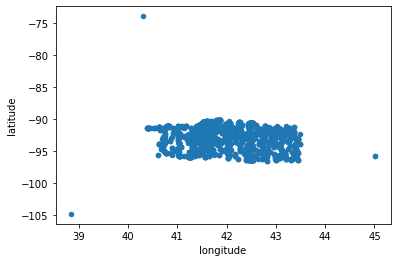

In [50]:
unique_shops.dropna().plot.scatter(x='longitude',y='latitude')

There are outliers. Let's drop them

In [51]:
data['longitude'] = data.longitude.map(lambda x: x if x>40 and x<44 else None)
data['latitude'] = data.latitude.map(lambda x: x if x>-97 and x<-87 else None)

In [53]:
unique_shops = data.groupby(['address','store_name','latitude','longitude'],as_index=False).sale_dollars.sum()

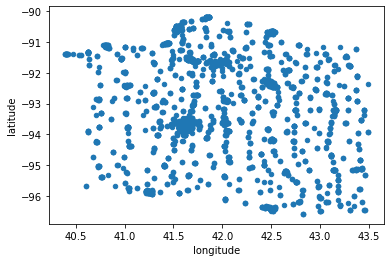

In [58]:
unique_shops.dropna().plot.scatter(x='longitude',y='latitude')